In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR
import os
import pandas as pd
from MyInceptionV4 import InceptionV4
from MyFramework import InceptionNet
from MyFramework import InceptionResNet
from MyVGG import VGG_A
from MyVGG import VGG_BatchNorm


In [2]:
device_id = 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]=str(device_id)

device = torch.device("cuda:{}".format(device_id) if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device_id))

cuda:0
NVIDIA RTX A6000


In [3]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # 如果使用Inception v4网络，需要调整为299
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 随机颜色变换
    transforms.RandomRotation(10),  # 随机旋转(-10, 10)度
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5,0.5)), 
])

transform_test = transforms.Compose([
    transforms.Resize(32),    # 如果使用Inception v4网络，需要调整为299
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5,0.5)),  
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

In [ ]:
# 选择网络
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG_A().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.0001, weight_decay=0.0001)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001) #0.001 for VGG
# optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
# optimizer = optim.RMSprop(model.parameters(), lr=0.0001, alpha=0.99, weight_decay=0.0001)

# 训练模型
def train(epoch):
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0
    pbar = tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch+1}")
    for batch_idx, (inputs, targets) in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()
        if batch_idx % 100 == 99:  # 每100个批次打印一次
            pbar.set_postfix({'Loss': running_loss / 100})
            running_loss = 0.0
    return epoch_loss / len(trainloader)

def test():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(enumerate(testloader), total=len(testloader), desc="Testing")
        for batch_idx, (inputs, targets) in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# 初始化列表以记录训练损失和测试精度
train_losses = []
test_accuracies = []
epoch_size = 200
# 执行训练和测试
for epoch in range(epoch_size):  # 训练100个epoch
    train_loss = train(epoch)
    train_losses.append(train_loss)
    test_accuracy = test()
    test_accuracies.append(test_accuracy)

# 输出最终的结果
print(f'Final Training Loss: {train_losses[-1]:.4f}')
print(f'Final Test Accuracy: {test_accuracies[-1]:.2f}%')

In [ ]:
plt.figure()
plt.plot(range(1, epoch_size+1), test_accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy over Epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, epoch_size+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


# 损失景观：

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt


learning_rates = [1e-3, 1e-4, 5e-4, 5e-5]
train_losses_dict = {lr: [] for lr in learning_rates}
test_accuracies_dict = {lr: [] for lr in learning_rates}
steps_dict = {lr: [] for lr in learning_rates}

# 定义训练函数
def train(epoch, model, optimizer, trainloader, device, lr):
    model.train()
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch+1}")
    for batch_idx, (inputs, targets) in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        steps_dict[lr].append(loss.item())  # 记录每一步的损失
        if batch_idx % 100 == 99:  # 每100个批次打印一次
            pbar.set_postfix({'Loss': running_loss / 100})
            running_loss = 0.0
    return running_loss / len(trainloader)

# 定义测试函数
def test(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(enumerate(testloader), total=len(testloader), desc="Testing")
        for batch_idx, (inputs, targets) in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 训练和测试每个学习率下的模型
epoch_size = 100
criterion = nn.CrossEntropyLoss()

for lr in learning_rates:
    # 每次都重新初始化模型和优化器
    model = VGG_A().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epoch_size):
        train_loss = train(epoch, model, optimizer, trainloader, device, lr)
        train_losses_dict[lr].append(train_loss)
        test_accuracy = test(model, testloader, device)
        test_accuracies_dict[lr].append(test_accuracy)

max_curve = []
min_curve = []

# 找到所有学习率下的最大步数
max_steps = max(len(steps_dict[lr]) for lr in learning_rates)

for step in range(max_steps):
    step_losses = []
    for lr in learning_rates:
        if step < len(steps_dict[lr]):
            step_losses.append(steps_dict[lr][step])
    max_curve.append(max(step_losses))
    min_curve.append(min(step_losses))


Testing: 100%|██████████| 100/100 [00:00<00:00, 221.52it/s]

Test Accuracy: 35.44%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.75it/s]

Test Accuracy: 47.96%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.74it/s]

Test Accuracy: 58.01%



Testing: 100%|██████████| 100/100 [00:00<00:00, 236.68it/s]

Test Accuracy: 62.50%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.22it/s]

Test Accuracy: 67.45%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.44it/s]

Test Accuracy: 69.89%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.50it/s]

Test Accuracy: 71.26%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.14it/s]

Test Accuracy: 72.68%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.57it/s]

Test Accuracy: 75.35%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.56it/s]

Test Accuracy: 74.93%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.16it/s]

Test Accuracy: 77.24%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.28it/s]

Test Accuracy: 77.28%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.44it/s]

Test Accuracy: 78.64%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.66it/s]

Test Accuracy: 76.04%



Testing: 100%|██████████| 100/100 [00:00<00:00, 228.38it/s]

Test Accuracy: 78.19%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.15it/s]

Test Accuracy: 79.19%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.90it/s]

Test Accuracy: 78.63%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.56it/s]

Test Accuracy: 79.50%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.06it/s]

Test Accuracy: 79.89%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.11it/s]

Test Accuracy: 79.67%



Testing: 100%|██████████| 100/100 [00:00<00:00, 236.22it/s]

Test Accuracy: 80.62%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.29it/s]

Test Accuracy: 80.04%



Testing: 100%|██████████| 100/100 [00:00<00:00, 236.20it/s]

Test Accuracy: 80.50%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.04it/s]

Test Accuracy: 81.22%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.36it/s]

Test Accuracy: 80.66%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.41it/s]

Test Accuracy: 81.87%



Testing: 100%|██████████| 100/100 [00:00<00:00, 236.94it/s]

Test Accuracy: 80.21%



Testing: 100%|██████████| 100/100 [00:00<00:00, 226.63it/s]

Test Accuracy: 81.24%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.22it/s]

Test Accuracy: 81.13%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.06it/s]

Test Accuracy: 81.11%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.70it/s]

Test Accuracy: 81.93%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.03it/s]

Test Accuracy: 82.07%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.66it/s]

Test Accuracy: 82.36%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.17it/s]

Test Accuracy: 82.00%



Testing: 100%|██████████| 100/100 [00:00<00:00, 235.78it/s]

Test Accuracy: 82.19%



Testing: 100%|██████████| 100/100 [00:00<00:00, 228.91it/s]

Test Accuracy: 81.17%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.86it/s]

Test Accuracy: 81.45%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.43it/s]

Test Accuracy: 81.29%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.97it/s]

Test Accuracy: 82.19%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.71it/s]

Test Accuracy: 82.51%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.01it/s]

Test Accuracy: 82.22%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.73it/s]

Test Accuracy: 81.80%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.78it/s]

Test Accuracy: 82.21%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.18it/s]

Test Accuracy: 82.17%



Testing: 100%|██████████| 100/100 [00:00<00:00, 228.81it/s]

Test Accuracy: 81.79%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.06it/s]

Test Accuracy: 82.51%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.14it/s]

Test Accuracy: 82.57%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.29it/s]

Test Accuracy: 82.08%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.37it/s]

Test Accuracy: 82.73%



Testing: 100%|██████████| 100/100 [00:00<00:00, 235.50it/s]

Test Accuracy: 82.25%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.71it/s]

Test Accuracy: 81.96%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.06it/s]

Test Accuracy: 82.67%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.35it/s]

Test Accuracy: 82.88%



Testing: 100%|██████████| 100/100 [00:00<00:00, 236.55it/s]

Test Accuracy: 83.03%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.54it/s]

Test Accuracy: 82.40%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.54it/s]

Test Accuracy: 83.15%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.33it/s]

Test Accuracy: 82.59%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.95it/s]

Test Accuracy: 83.09%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.64it/s]

Test Accuracy: 83.33%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.71it/s]

Test Accuracy: 82.93%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.40it/s]

Test Accuracy: 83.25%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.80it/s]

Test Accuracy: 82.56%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.78it/s]

Test Accuracy: 82.60%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.21it/s]

Test Accuracy: 83.84%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.29it/s]

Test Accuracy: 82.95%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.16it/s]

Test Accuracy: 83.41%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.27it/s]

Test Accuracy: 82.84%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.44it/s]

Test Accuracy: 83.29%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.37it/s]

Test Accuracy: 82.99%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.13it/s]

Test Accuracy: 83.37%



Testing: 100%|██████████| 100/100 [00:00<00:00, 225.22it/s]

Test Accuracy: 83.55%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.63it/s]

Test Accuracy: 83.63%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.02it/s]

Test Accuracy: 83.42%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.06it/s]

Test Accuracy: 83.39%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.11it/s]

Test Accuracy: 83.16%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.17it/s]

Test Accuracy: 83.21%



Testing: 100%|██████████| 100/100 [00:00<00:00, 218.40it/s]

Test Accuracy: 84.23%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.90it/s]

Test Accuracy: 83.28%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.16it/s]

Test Accuracy: 83.39%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.84it/s]

Test Accuracy: 83.55%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.19it/s]

Test Accuracy: 83.34%



Testing: 100%|██████████| 100/100 [00:00<00:00, 225.64it/s]

Test Accuracy: 83.52%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.80it/s]

Test Accuracy: 84.30%



Testing: 100%|██████████| 100/100 [00:00<00:00, 235.70it/s]

Test Accuracy: 83.71%



Testing: 100%|██████████| 100/100 [00:00<00:00, 235.23it/s]

Test Accuracy: 84.15%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.94it/s]

Test Accuracy: 83.98%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.92it/s]

Test Accuracy: 83.86%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.25it/s]

Test Accuracy: 83.42%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.31it/s]

Test Accuracy: 83.89%



Testing: 100%|██████████| 100/100 [00:00<00:00, 235.10it/s]

Test Accuracy: 83.52%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.50it/s]

Test Accuracy: 83.97%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.25it/s]

Test Accuracy: 83.82%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.01it/s]

Test Accuracy: 82.32%



Testing: 100%|██████████| 100/100 [00:00<00:00, 237.06it/s]

Test Accuracy: 83.94%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.76it/s]

Test Accuracy: 84.12%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.80it/s]

Test Accuracy: 84.60%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.94it/s]

Test Accuracy: 84.53%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.54it/s]

Test Accuracy: 83.91%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.31it/s]

Test Accuracy: 83.68%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.59it/s]

Test Accuracy: 83.91%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.85it/s]

Test Accuracy: 37.66%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.03it/s]

Test Accuracy: 42.15%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.60it/s]

Test Accuracy: 52.14%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.80it/s]

Test Accuracy: 58.33%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.53it/s]

Test Accuracy: 61.69%



Testing: 100%|██████████| 100/100 [00:00<00:00, 236.34it/s]

Test Accuracy: 64.99%



Testing: 100%|██████████| 100/100 [00:00<00:00, 228.67it/s]

Test Accuracy: 65.90%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.83it/s]

Test Accuracy: 66.64%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.50it/s]

Test Accuracy: 72.68%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.87it/s]

Test Accuracy: 72.42%



Testing: 100%|██████████| 100/100 [00:00<00:00, 236.15it/s]

Test Accuracy: 72.99%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.54it/s]

Test Accuracy: 71.36%



Testing: 100%|██████████| 100/100 [00:00<00:00, 235.89it/s]

Test Accuracy: 75.64%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.38it/s]

Test Accuracy: 77.53%



Testing: 100%|██████████| 100/100 [00:00<00:00, 235.27it/s]

Test Accuracy: 76.39%



Testing: 100%|██████████| 100/100 [00:00<00:00, 235.56it/s]

Test Accuracy: 77.21%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.05it/s]

Test Accuracy: 79.72%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.32it/s]

Test Accuracy: 79.23%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.97it/s]

Test Accuracy: 80.15%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.57it/s]

Test Accuracy: 79.72%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.03it/s]

Test Accuracy: 80.84%



Testing: 100%|██████████| 100/100 [00:00<00:00, 226.44it/s]

Test Accuracy: 80.49%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.91it/s]

Test Accuracy: 81.13%



Testing: 100%|██████████| 100/100 [00:00<00:00, 225.92it/s]

Test Accuracy: 80.98%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.61it/s]

Test Accuracy: 81.79%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.06it/s]

Test Accuracy: 82.11%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.63it/s]

Test Accuracy: 81.27%



Testing: 100%|██████████| 100/100 [00:00<00:00, 228.97it/s]

Test Accuracy: 82.16%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.94it/s]

Test Accuracy: 82.67%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.70it/s]

Test Accuracy: 82.62%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.58it/s]

Test Accuracy: 83.22%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.36it/s]

Test Accuracy: 83.19%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.68it/s]

Test Accuracy: 82.16%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.78it/s]

Test Accuracy: 83.23%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.15it/s]

Test Accuracy: 82.96%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.22it/s]

Test Accuracy: 83.47%



Testing: 100%|██████████| 100/100 [00:00<00:00, 237.72it/s]

Test Accuracy: 82.64%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.63it/s]

Test Accuracy: 83.53%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.52it/s]

Test Accuracy: 83.06%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.43it/s]

Test Accuracy: 83.76%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.04it/s]

Test Accuracy: 83.49%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.83it/s]

Test Accuracy: 83.52%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.74it/s]

Test Accuracy: 83.25%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.97it/s]

Test Accuracy: 83.26%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.03it/s]

Test Accuracy: 83.58%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.99it/s]

Test Accuracy: 83.33%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.35it/s]

Test Accuracy: 84.34%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.62it/s]

Test Accuracy: 84.13%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.14it/s]

Test Accuracy: 83.78%



Testing: 100%|██████████| 100/100 [00:00<00:00, 228.29it/s]

Test Accuracy: 83.99%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.39it/s]

Test Accuracy: 84.16%



Testing: 100%|██████████| 100/100 [00:00<00:00, 226.78it/s]

Test Accuracy: 84.36%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.44it/s]

Test Accuracy: 84.12%



Testing: 100%|██████████| 100/100 [00:00<00:00, 228.90it/s]

Test Accuracy: 83.76%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.94it/s]

Test Accuracy: 83.24%



Testing: 100%|██████████| 100/100 [00:00<00:00, 225.80it/s]

Test Accuracy: 83.60%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.92it/s]

Test Accuracy: 83.94%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.71it/s]

Test Accuracy: 84.86%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.89it/s]

Test Accuracy: 84.39%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.25it/s]

Test Accuracy: 83.76%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.68it/s]

Test Accuracy: 84.06%



Testing: 100%|██████████| 100/100 [00:00<00:00, 226.84it/s]

Test Accuracy: 84.10%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.68it/s]

Test Accuracy: 83.08%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.00it/s]

Test Accuracy: 83.99%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.10it/s]

Test Accuracy: 84.37%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.28it/s]

Test Accuracy: 83.21%



Testing: 100%|██████████| 100/100 [00:00<00:00, 228.03it/s]

Test Accuracy: 83.35%



Testing: 100%|██████████| 100/100 [00:00<00:00, 235.90it/s]

Test Accuracy: 84.35%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.44it/s]

Test Accuracy: 84.35%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.30it/s]

Test Accuracy: 84.83%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.50it/s]

Test Accuracy: 84.60%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.80it/s]

Test Accuracy: 84.28%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.14it/s]

Test Accuracy: 84.65%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.68it/s]

Test Accuracy: 84.87%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.21it/s]

Test Accuracy: 84.31%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.74it/s]

Test Accuracy: 84.51%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.59it/s]

Test Accuracy: 85.01%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.68it/s]

Test Accuracy: 84.31%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.13it/s]

Test Accuracy: 84.58%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.00it/s]

Test Accuracy: 84.58%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.03it/s]

Test Accuracy: 84.15%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.02it/s]

Test Accuracy: 84.16%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.88it/s]

Test Accuracy: 84.41%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.00it/s]

Test Accuracy: 83.59%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.61it/s]

Test Accuracy: 84.86%



Testing: 100%|██████████| 100/100 [00:00<00:00, 228.65it/s]

Test Accuracy: 84.31%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.45it/s]

Test Accuracy: 84.96%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.24it/s]

Test Accuracy: 84.86%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.07it/s]

Test Accuracy: 85.32%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.91it/s]

Test Accuracy: 84.96%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.88it/s]

Test Accuracy: 85.14%



Testing: 100%|██████████| 100/100 [00:00<00:00, 225.35it/s]

Test Accuracy: 84.66%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.05it/s]

Test Accuracy: 85.25%



Testing: 100%|██████████| 100/100 [00:00<00:00, 228.17it/s]

Test Accuracy: 84.79%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.99it/s]

Test Accuracy: 85.02%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.89it/s]

Test Accuracy: 84.21%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.03it/s]

Test Accuracy: 84.11%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.10it/s]

Test Accuracy: 84.86%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.04it/s]

Test Accuracy: 84.72%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.88it/s]

Test Accuracy: 84.70%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.55it/s]

Test Accuracy: 34.66%



Testing: 100%|██████████| 100/100 [00:00<00:00, 226.59it/s]

Test Accuracy: 49.38%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.86it/s]

Test Accuracy: 56.69%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.36it/s]

Test Accuracy: 66.11%



Testing: 100%|██████████| 100/100 [00:00<00:00, 228.09it/s]

Test Accuracy: 69.70%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.04it/s]

Test Accuracy: 69.92%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.14it/s]

Test Accuracy: 73.02%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.49it/s]

Test Accuracy: 74.79%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.70it/s]

Test Accuracy: 75.45%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.65it/s]

Test Accuracy: 77.83%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.51it/s]

Test Accuracy: 78.72%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.19it/s]

Test Accuracy: 79.07%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.73it/s]

Test Accuracy: 79.88%



Testing: 100%|██████████| 100/100 [00:00<00:00, 225.65it/s]

Test Accuracy: 80.26%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.69it/s]

Test Accuracy: 80.21%



Testing: 100%|██████████| 100/100 [00:00<00:00, 236.26it/s]

Test Accuracy: 81.92%



Testing: 100%|██████████| 100/100 [00:00<00:00, 235.65it/s]

Test Accuracy: 81.29%



Testing: 100%|██████████| 100/100 [00:00<00:00, 228.81it/s]

Test Accuracy: 81.22%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.62it/s]

Test Accuracy: 81.06%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.10it/s]

Test Accuracy: 82.31%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.19it/s]

Test Accuracy: 81.69%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.92it/s]

Test Accuracy: 82.53%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.71it/s]

Test Accuracy: 82.92%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.00it/s]

Test Accuracy: 83.37%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.19it/s]

Test Accuracy: 83.72%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.43it/s]

Test Accuracy: 83.03%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.48it/s]

Test Accuracy: 83.26%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.88it/s]

Test Accuracy: 82.33%



Testing: 100%|██████████| 100/100 [00:00<00:00, 228.51it/s]

Test Accuracy: 83.77%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.93it/s]

Test Accuracy: 84.18%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.26it/s]

Test Accuracy: 82.93%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.18it/s]

Test Accuracy: 82.77%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.20it/s]

Test Accuracy: 83.73%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.42it/s]

Test Accuracy: 83.73%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.16it/s]

Test Accuracy: 84.70%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.60it/s]

Test Accuracy: 83.44%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.17it/s]

Test Accuracy: 84.21%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.07it/s]

Test Accuracy: 83.96%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.59it/s]

Test Accuracy: 84.27%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.62it/s]

Test Accuracy: 83.88%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.27it/s]

Test Accuracy: 83.68%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.43it/s]

Test Accuracy: 84.28%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.95it/s]

Test Accuracy: 85.15%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.73it/s]

Test Accuracy: 84.49%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.90it/s]

Test Accuracy: 84.30%



Testing: 100%|██████████| 100/100 [00:00<00:00, 225.98it/s]

Test Accuracy: 84.57%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.97it/s]

Test Accuracy: 84.71%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.29it/s]

Test Accuracy: 84.29%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.06it/s]

Test Accuracy: 84.02%



Testing: 100%|██████████| 100/100 [00:00<00:00, 225.29it/s]

Test Accuracy: 84.79%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.87it/s]

Test Accuracy: 84.21%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.96it/s]

Test Accuracy: 84.77%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.26it/s]

Test Accuracy: 85.00%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.03it/s]

Test Accuracy: 84.05%



Testing: 100%|██████████| 100/100 [00:00<00:00, 225.15it/s]

Test Accuracy: 84.61%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.52it/s]

Test Accuracy: 84.79%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.71it/s]

Test Accuracy: 84.44%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.73it/s]

Test Accuracy: 84.93%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.31it/s]

Test Accuracy: 84.49%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.10it/s]

Test Accuracy: 84.65%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.26it/s]

Test Accuracy: 84.47%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.88it/s]

Test Accuracy: 84.85%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.88it/s]

Test Accuracy: 84.61%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.36it/s]

Test Accuracy: 84.89%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.84it/s]

Test Accuracy: 84.25%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.89it/s]

Test Accuracy: 85.04%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.73it/s]

Test Accuracy: 85.10%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.74it/s]

Test Accuracy: 84.64%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.88it/s]

Test Accuracy: 84.74%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.89it/s]

Test Accuracy: 85.44%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.39it/s]

Test Accuracy: 85.30%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.26it/s]

Test Accuracy: 84.88%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.70it/s]

Test Accuracy: 84.46%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.66it/s]

Test Accuracy: 85.34%



Testing: 100%|██████████| 100/100 [00:00<00:00, 228.58it/s]

Test Accuracy: 84.52%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.24it/s]

Test Accuracy: 85.15%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.81it/s]

Test Accuracy: 84.93%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.98it/s]

Test Accuracy: 84.33%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.58it/s]

Test Accuracy: 85.10%



Testing: 100%|██████████| 100/100 [00:00<00:00, 228.09it/s]

Test Accuracy: 84.67%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.14it/s]

Test Accuracy: 85.00%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.32it/s]

Test Accuracy: 85.00%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.12it/s]

Test Accuracy: 84.11%



Testing: 100%|██████████| 100/100 [00:00<00:00, 236.96it/s]

Test Accuracy: 85.13%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.02it/s]

Test Accuracy: 85.27%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.80it/s]

Test Accuracy: 85.05%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.07it/s]

Test Accuracy: 85.49%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.04it/s]

Test Accuracy: 85.39%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.88it/s]

Test Accuracy: 84.97%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.95it/s]

Test Accuracy: 84.82%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.96it/s]

Test Accuracy: 85.78%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.76it/s]

Test Accuracy: 85.53%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.87it/s]

Test Accuracy: 84.75%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.86it/s]

Test Accuracy: 84.47%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.01it/s]

Test Accuracy: 84.21%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.84it/s]

Test Accuracy: 84.67%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.10it/s]

Test Accuracy: 85.21%



Testing: 100%|██████████| 100/100 [00:00<00:00, 235.96it/s]

Test Accuracy: 84.82%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.62it/s]

Test Accuracy: 84.85%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.88it/s]

Test Accuracy: 85.75%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.37it/s]

Test Accuracy: 32.71%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.98it/s]

Test Accuracy: 38.44%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.54it/s]

Test Accuracy: 40.64%



Testing: 100%|██████████| 100/100 [00:00<00:00, 226.47it/s]

Test Accuracy: 45.89%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.96it/s]

Test Accuracy: 47.23%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.12it/s]

Test Accuracy: 49.79%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.34it/s]

Test Accuracy: 52.86%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.19it/s]

Test Accuracy: 56.70%



Testing: 100%|██████████| 100/100 [00:00<00:00, 226.23it/s]

Test Accuracy: 57.84%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.32it/s]

Test Accuracy: 60.90%



Testing: 100%|██████████| 100/100 [00:00<00:00, 224.72it/s]

Test Accuracy: 62.34%



Testing: 100%|██████████| 100/100 [00:00<00:00, 226.00it/s]

Test Accuracy: 63.45%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.38it/s]

Test Accuracy: 64.81%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.11it/s]

Test Accuracy: 64.53%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.00it/s]

Test Accuracy: 67.94%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.27it/s]

Test Accuracy: 68.00%



Testing: 100%|██████████| 100/100 [00:00<00:00, 226.03it/s]

Test Accuracy: 69.93%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.96it/s]

Test Accuracy: 69.11%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.15it/s]

Test Accuracy: 70.07%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.47it/s]

Test Accuracy: 72.10%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.62it/s]

Test Accuracy: 72.76%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.13it/s]

Test Accuracy: 72.65%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.13it/s]

Test Accuracy: 73.97%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.80it/s]

Test Accuracy: 73.78%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.36it/s]

Test Accuracy: 75.69%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.64it/s]

Test Accuracy: 75.19%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.74it/s]

Test Accuracy: 76.20%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.68it/s]

Test Accuracy: 76.91%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.04it/s]

Test Accuracy: 76.92%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.40it/s]

Test Accuracy: 75.06%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.28it/s]

Test Accuracy: 78.28%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.00it/s]

Test Accuracy: 78.69%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.03it/s]

Test Accuracy: 78.22%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.32it/s]

Test Accuracy: 77.28%



Testing: 100%|██████████| 100/100 [00:00<00:00, 228.78it/s]

Test Accuracy: 78.59%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.41it/s]

Test Accuracy: 78.34%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.71it/s]

Test Accuracy: 79.94%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.34it/s]

Test Accuracy: 78.66%



Testing: 100%|██████████| 100/100 [00:00<00:00, 234.42it/s]

Test Accuracy: 80.20%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.24it/s]

Test Accuracy: 79.93%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.53it/s]

Test Accuracy: 80.10%



Testing: 100%|██████████| 100/100 [00:00<00:00, 228.54it/s]

Test Accuracy: 81.47%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.98it/s]

Test Accuracy: 80.67%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.08it/s]

Test Accuracy: 81.06%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.89it/s]

Test Accuracy: 80.29%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.87it/s]

Test Accuracy: 79.91%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.07it/s]

Test Accuracy: 81.14%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.31it/s]

Test Accuracy: 80.85%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.37it/s]

Test Accuracy: 80.92%



Testing: 100%|██████████| 100/100 [00:00<00:00, 226.83it/s]

Test Accuracy: 81.58%



Testing: 100%|██████████| 100/100 [00:00<00:00, 225.00it/s]

Test Accuracy: 81.85%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.87it/s]

Test Accuracy: 81.80%



Testing: 100%|██████████| 100/100 [00:00<00:00, 228.19it/s]

Test Accuracy: 81.70%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.87it/s]

Test Accuracy: 81.24%



Testing: 100%|██████████| 100/100 [00:00<00:00, 228.37it/s]

Test Accuracy: 81.17%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.09it/s]

Test Accuracy: 82.30%



Testing: 100%|██████████| 100/100 [00:00<00:00, 225.74it/s]

Test Accuracy: 82.59%



Testing: 100%|██████████| 100/100 [00:00<00:00, 226.68it/s]

Test Accuracy: 82.65%



Testing: 100%|██████████| 100/100 [00:00<00:00, 227.25it/s]

Test Accuracy: 81.86%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.02it/s]

Test Accuracy: 81.91%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.68it/s]

Test Accuracy: 81.81%



Testing: 100%|██████████| 100/100 [00:00<00:00, 225.95it/s]

Test Accuracy: 81.66%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.00it/s]

Test Accuracy: 81.74%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.31it/s]

Test Accuracy: 82.02%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.18it/s]

Test Accuracy: 82.33%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.35it/s]

Test Accuracy: 82.10%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.82it/s]

Test Accuracy: 81.30%



Testing: 100%|██████████| 100/100 [00:00<00:00, 223.76it/s]

Test Accuracy: 82.53%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.21it/s]

Test Accuracy: 82.37%



Testing: 100%|██████████| 100/100 [00:00<00:00, 228.80it/s]

Test Accuracy: 82.33%



Testing: 100%|██████████| 100/100 [00:00<00:00, 233.11it/s]

Test Accuracy: 81.47%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.69it/s]

Test Accuracy: 82.75%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.08it/s]

Test Accuracy: 80.77%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.35it/s]

Test Accuracy: 83.16%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.55it/s]

Test Accuracy: 82.41%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.59it/s]

Test Accuracy: 82.35%



Testing: 100%|██████████| 100/100 [00:00<00:00, 236.08it/s]

Test Accuracy: 83.10%



Testing: 100%|██████████| 100/100 [00:00<00:00, 225.52it/s]

Test Accuracy: 82.49%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.24it/s]

Test Accuracy: 82.28%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.40it/s]

Test Accuracy: 82.63%



Testing: 100%|██████████| 100/100 [00:00<00:00, 225.09it/s]

Test Accuracy: 82.37%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.34it/s]

Test Accuracy: 83.01%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.98it/s]

Test Accuracy: 83.01%



Testing: 100%|██████████| 100/100 [00:00<00:00, 225.10it/s]

Test Accuracy: 82.96%



Testing: 100%|██████████| 100/100 [00:00<00:00, 228.12it/s]

Test Accuracy: 83.38%



Testing: 100%|██████████| 100/100 [00:00<00:00, 230.94it/s]

Test Accuracy: 82.98%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.20it/s]

Test Accuracy: 83.46%



Testing: 100%|██████████| 100/100 [00:00<00:00, 224.70it/s]

Test Accuracy: 82.64%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.09it/s]

Test Accuracy: 83.15%



Testing: 100%|██████████| 100/100 [00:00<00:00, 228.45it/s]

Test Accuracy: 83.24%



Testing: 100%|██████████| 100/100 [00:00<00:00, 225.79it/s]

Test Accuracy: 83.20%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.20it/s]

Test Accuracy: 82.92%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.80it/s]

Test Accuracy: 83.06%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.69it/s]

Test Accuracy: 83.34%



Testing: 100%|██████████| 100/100 [00:00<00:00, 229.31it/s]

Test Accuracy: 83.07%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.23it/s]

Test Accuracy: 82.88%



Testing: 100%|██████████| 100/100 [00:00<00:00, 231.46it/s]

Test Accuracy: 82.84%



Testing: 100%|██████████| 100/100 [00:00<00:00, 226.27it/s]

Test Accuracy: 83.30%



Testing: 100%|██████████| 100/100 [00:00<00:00, 232.74it/s]

Test Accuracy: 82.62%



Testing: 100%|██████████| 100/100 [00:00<00:00, 224.85it/s]

Test Accuracy: 82.48%


In [5]:
pd.DataFrame(steps_dict)

,0.00100,0.00010,0.00050,0.00005
0,2.303299,2.305228,2.300539,2.301166
1,2.303428,2.299906,2.303836,2.301745
2,2.305563,2.302409,2.302433,2.307853
3,2.303114,2.301602,2.300808,2.305148
4,2.300057,2.303525,2.304745,2.305660
...,...,...,...,...
49995,0.182204,0.077243,0.122416,0.104071
49996,0.260271,0.095607,0.099506,0.228845
49997,0.311737,0.069199,0.070063,0.046395
49998,0.183362,0.061426,0.181628,0.148762


In [6]:
df = pd.DataFrame()
df.index = range(1, epoch_size*500+1)
df['max_curve'] = max_curve
df['min_curve'] = min_curve
df

df.to_pickle("VGG_A_LandScape_byStep.pkl")

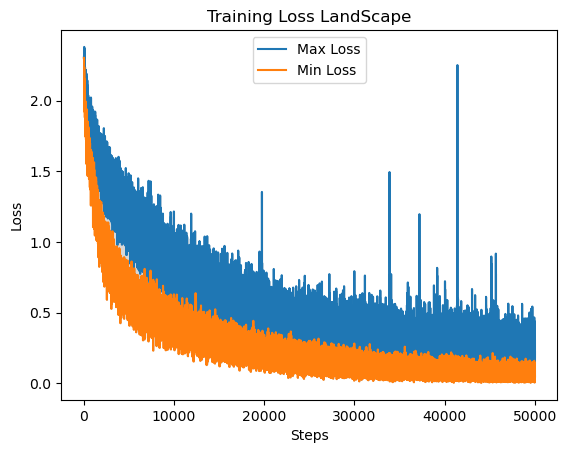

In [7]:
plt.figure()
plt.plot(range(1, epoch_size*500+1), max_curve, label='Max Loss')
plt.plot(range(1, epoch_size*500+1), min_curve, label='Min Loss')
plt.fill_between(range(1, epoch_size*500+1), min_curve, max_curve, color='gray', alpha=0.3)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss LandScape')
plt.legend()
plt.show()

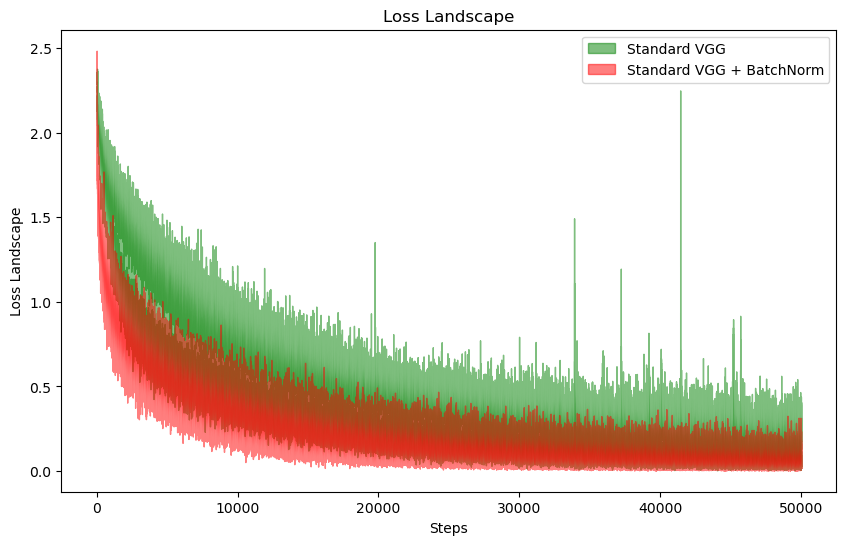

In [8]:
VGG_A_LandScape = pd.read_pickle("VGG_A_LandScape_byStep.pkl")
VGG_BN_LandScape = pd.read_pickle("VGG_BN_LandScape_byStep.pkl")
plt.figure(figsize=(10, 6))

# Standard VGG
plt.fill_between(range(1, len(VGG_A_LandScape) + 1), VGG_A_LandScape['max_curve'], VGG_A_LandScape['min_curve'], color='green', alpha=0.5, label='Standard VGG')

# Standard VGG + BatchNorm
plt.fill_between(range(1, len(VGG_BN_LandScape) + 1), VGG_BN_LandScape['max_curve'], VGG_BN_LandScape['min_curve'], color='red', alpha=0.5, label='Standard VGG + BatchNorm')

# Labels and Title
plt.xlabel('Steps')
plt.ylabel('Loss Landscape')
plt.title('Loss Landscape')
plt.legend()

# Show plot
plt.show()